**Libraries Used in the Project:**
* pycryptodome: used the DSA, DSS, and SHA512 modules from this library to implement digital signatures (install using **pip install pycryptodomex** OR **conda install pycryptodomex**)
* json: used to save the files in the json format.
* random: used for the randomized simulator.
* decimal: used for accurate monetary arithmetic.


**Assumptions and Design Notes:**
* Transaction amount is the sum of the values of the coins created in the transaction (Not stored explicitly, but amount is specified for each receiver)
* Each transaction may have two recipients: the receiver gets the payment, the payer gets the remainder.
* The simulator allows to generate random valid transactions.
* The simulator allows to generate random attacks.
* The simulation assumes that the blockchain is secure all the time.
* The simulation assumes that there is no need to print the initial scrooge coin creation transactions.

In [ ]:
# Code Block 1
# -*- coding: utf-8 -*-

!pip install pycryptodomex

from Cryptodome.PublicKey import DSA
from Cryptodome.Signature import DSS
from Cryptodome.Hash import SHA512

import json
import random
from decimal import *
import numpy as np
getcontext().prec = 28
random.seed(0)
SIZE_BLOCK = 10
NUMBER_OF_USERS = 10

def print_console_and_file(output):
    print(output)
    with open('output.txt', 'a') as file_out:
        print(output, file=file_out)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Blockchain ##

* Blockchain technology refers to the technique of storing information in a way that it’s impossible or difficult to alter or manipulate the information.
* The information to be stored is duplicated and shared across all the participant nodes (e.g. computers) in the network of connected peers.
* In blockchain, the information is stored as the form of transactions of information/assets between users. An asset can be tangible (e.g. coin, car, cash, house, etc) or intangible (copyrights, intellectual properties, etc).
* Again, the assets can be considered fungible or non-fungible. Fungible assets refer that the values and properties of two assets can be the same (e.g. cash). But the values and properties of two non-fungible assets won’t ever be the same (e.g. copyrights). In our experiment, we will work with a type of fungible asset (ScroogeCoin) to simulate a simplistic blockchain.
* Blockchain maintains a structure named block which holds the record of transactions. A block can contain multiple transactions and the numeric threshold of transaction count in a block is restricted by the designer of the blockchain. 
* Every blockchain is initialized with a genesis block containing the configuration information of the blockchain and it’s considered the first block.
* When new transactions are created, they are verified and then listed in a block until the threshold of that block is reached.
* When a block containing transactions is created and verified, it’s linked to the previous block to form a chain of blocks. The order of the blocks are strictly maintained in the chain and each block maintains a link/pointer of its previous block. These pointers enable anyone to iterate the chain from the latest block till the genesis block. 
* The chain of blocks is the storage of transactional information and is shared across the network. So, the term, **distributed ledger** is used to refer to the blockchain.
* In blockchain, each transaction in a block is digitally signed using the private key of the transaction owner/originator which enables the authorization and authentication of every transaction. Adopting the digital signature mechanism makes the information stored in the blockchain highly secure and tamper-proof against attackers.



**The participants in the network are maintaining the same copy of the ledger.**<br>
>>>>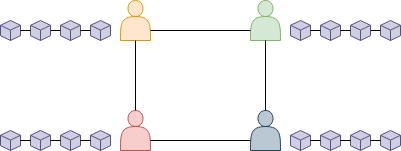

**Basic format of the blocks and the chain:** <br>

>>> 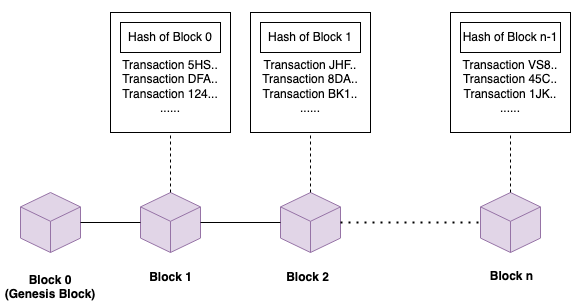

In [ ]:
# Code Block 2
class Blockchain:
    # The first block of a blockchain is called a Genesis block
    # For simplicity, we are creating an empty Hash Pointer as the Genesis block
    # Generally, Genesis block contains information about the configuration of the blockchain
    def __init__(self):
        self.final_hash_pointer = Hash_Pointer(None, None)
        self.final_block_scrooge_signature = None

    # When a new block needs is added to the blockchain, the final hash pointer is updated by the hash pointer of the new block
    # We also update the signature of the last block in the blockchain
    def add_block(self, block, hash_value, signature):
        self.final_hash_pointer = Hash_Pointer(block, hash_value)
        self.final_block_scrooge_signature = signature

    def generate_blockchain_string(self):
        data = {}
        data['final_block_hash_pointer'] = {
            'pointer': str(self.final_hash_pointer.get_pointer()),
            'hash': self.final_hash_pointer.get_hash_value(),
            'scrooge_signature': str(self.final_block_scrooge_signature)
        }

        block = self.final_hash_pointer.get_pointer()

        while block:
            data[block.get_id()] = block.generate_slip(as_dict=True)
            data[block.get_id()]['hash'] = block.get_hash_value()
            block = block.get_previous_hash_pointer().get_pointer()
        
        return json.dumps(data, sort_keys=False, indent=4, ensure_ascii=False)


**Transaction Class:** <br>
* Object of this class refers to a transaction of coins between users.
* Coins are first created in the form of transactions. Every other transaction has coin values and a receipient associated to it.
* Every transaction uses one or more other previous transactions with unspent coins as the basis or input of that transaction. In a transaction, fractional coin values can be tranferred.
* The recipient receives a fraction of the coin values (spent coin values) and the remaining coin value is considered unspent and the payer of this transaction can use the remaining coin value as the basis of later transactions.
* Before adding a transaction to the ledger, digital signature of the transaction is generated using the private key of the payer for the purpose of integrity verification (described later in details). 

**Input-output format of transactions:**

>>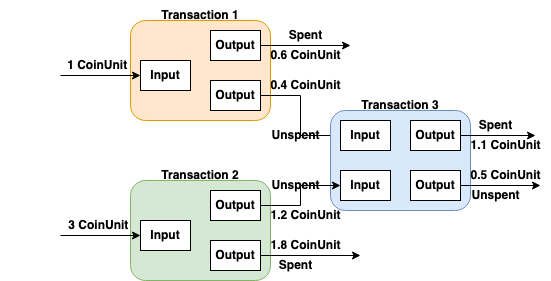

* In the **Transaction** class, the attributes named **transaction_id** (unique identifier of a transaction), **transaction_type** (coin creation or coin value transfer), **consumed_coins_ids**, **coins_created** are maintained in a transaction
* **consumed_coins_ids** refers to pointer of the coins to be spent or taken as input in the transaction
* **coins_created** refers to the pointer of the coins created as the transaction output




In [ ]:
# Code Block 3
class Transaction:
    def __init__(self, transaction_type, consumed_coins_ids, values, recepients):
        # Unique transaction id to keep track of a transaction
        self.transaction_id = str(self)

        # Attribute to store the type of the transaction
        self.transaction_type = transaction_type 

        # List of coins spent in this transaction
        self.consumed_coins_ids = consumed_coins_ids

        # Checking if the number of recepients matches the number of provided coins
        if len(values) != len(recepients):
            raise Exception('The number of coins and recepients is not equal')
        
        self.coins_created = {} # A dictionary to store the coins to be created or transferred in the transaction

        # For all the elements in the values list representing the value of the coins, 
        # a JSON containing coin value and its recepient is added to the coins_created dictionary 
        for serial_num in range(len(values)):
            self.coins_created[serial_num] = {
                'value': values[serial_num],
                'recepient': recepients[serial_num]
            }
    
    # This method generates a JSON object representing the transaction
    # Transaction id and type as well as the details about consumed and created coins are included in the JSON
    def generate_slip(self, asdict=False):
        slip = {}
        slip['id'] = str(self)
        slip['type'] = self.transaction_type
        
        slip['coins_consumed'] = {}
        for index in range(len(self.consumed_coins_ids)):
            slip['coins_consumed'][index] = {
                'transaction_id': str(self.consumed_coins_ids[index].get_pointer()),
                'transaction_hash': self.consumed_coins_ids[index].get_hash_value().hexdigest(),
                'coin_serial_number': self.consumed_coins_ids[index].get_coin_serial_num()
            }

        slip['coins_created'] = {}
        for index in range(len(self.coins_created)):
            slip['coins_created'][index] = {
                'value': str(self.coins_created[index]['value']),
                'recepient': self.coins_created[index]['recepient'].export_key().decode()
            }
        
        if asdict:
            return slip
        else:
            return json.dumps(slip, indent=4, ensure_ascii=False)
    
    # Method to set the signature of the transaction
    def add_signature(self, signature):
        self.signature = signature

    # Method to get the signature of the transaction
    def get_signature(self):
        return self.signature


**Hash_Pointer Class:**
* Object of this class can be used to hold unique reference to a **Block** or **Transaction**.
* When the pointer refers to a **Block**, the reference to the block and the hash of the block are stored as class attributes.
* When the pointer refers to a **Transaction**, the serial number of the coin in the transaction is also maintained along with the reference to the transaction and the hash of the transaction.

In [ ]:
# Code Block 4
class Hash_Pointer:
    # Hash pointer can be created for a block or a transaction
    # Listed attributes are __hash_value, __pointer, __coin_serial_num
    def __init__(self, pointer, hash_value, coin_serial_num=None):
        self.__hash_value = hash_value
        self.__pointer = pointer
        self.__coin_serial_num = coin_serial_num
    
    # Method to fetch the stored hash value
    def get_hash_value(self):
        return self.__hash_value
    
    # Method to fetch the stored pointer
    def get_pointer(self):
        return self.__pointer

    # Method to fetch the stored coin serial number
    def get_coin_serial_num(self):
        return self.__coin_serial_num
    
    # Method to check if a passed hash pointer is equal to the current hash pointer
    def equals(self, other_hash_pointer):
        return (
            self.get_pointer() is other_hash_pointer.get_pointer() # Checking if the pointers are equal
            ) and (
                self.get_hash_value() == other_hash_pointer.get_hash_value() # Checking if the hash values are equal
                ) and (
                    self.get_coin_serial_num() == other_hash_pointer.get_coin_serial_num()  # Checking if the coin serial numbers are equal
                    )

**Block Class:**
*  In blockchain, a block contains a list of transactions between users.
* As all the blocks are chained together, each block must hold the pointer to the previous block (Exception: Genesis block).
* Genesis block is the first block in the blockchain.
* A block can contain various information as shown in the figure below. But for simplicity, only **block id, hash pointer to the previous block**, and **block hash** are maintained in a block in this simulation.

>>> 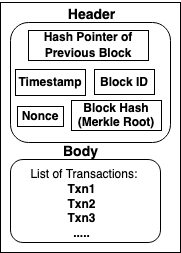

In [ ]:
# Code Block 5
class Block:
    def __init__(self, transactions, previous_block_hash_pointer):
        # The list of transactions that will be written in this block
        self.__transactions = transactions

        # Unique block id 
        self.__block_id = str(self)

        # Pointer to previous block
        self.__previous_block_hash_pointer = previous_block_hash_pointer
    
    # This function returns the unique block id
    def get_id(self):
        return self.__block_id

    # This function returns the hash pointer of previous block. 
    # It will help us find the preceding block in the chain so that we can iterate the entire chain 
    def get_previous_hash_pointer(self):
        return self.__previous_block_hash_pointer

    def generate_slip(self, as_dict=False):
        slip = {}

        slip['block_id'] = self.__block_id
        slip['previous_block_pointer'] = str(self.__previous_block_hash_pointer.get_pointer())
        slip['previous_block_hash_value'] = self.__previous_block_hash_pointer.get_hash_value()
        
        slip['transactions'] = {}
        for index in range(len(self.__transactions)):
            slip['transactions'][index] = {
                'transaction_body': self.__transactions[index].generate_slip(asdict=True),
                'signature': str(self.__transactions[index].signature)
            }

        if as_dict:
            return slip
        else:
            return json.dumps(slip, sort_keys=False, indent=4, ensure_ascii=False)
    
    def add_hash_value(self, hash_value):
        self.__hash_value = hash_value
    
    def get_hash_value(self):
        return self.__hash_value
    
    def get_transactions(self):
        return self.__transactions

**User Class**: <br> 
* This class can be used to create users and handle the activities of the users which includes querying the balance from the transactions of a user, generating digital signature using user's private key, etc.
* The list of all transactions and also spent transactions generated by a User are maintained in a **User** object's **ewallet** and **spent_before** lists.
* Before transactions are listed and published in a block, the list of the all temporary transactions and unspent transactions are maintained **ewallet_temp** and **spent_before_temp** list respectively.
* User can sign any transaction with the **private key** using **sign_transaction()** method
* When a block is published containing the temporary transactions of the user, it means those transactions are verified and confirmed, and will be added to user's **ewallet** and **spent_before** lists.

  **Signing the Transaction by user to generate Digital Signature:** <br> <br>
>>>> 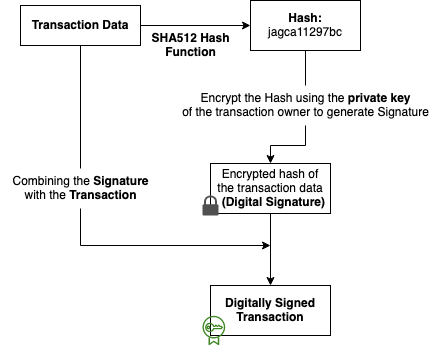





In [ ]:
# Code Block 6
class User:  
    # A list name spent_before is maintained to keep track of the coins which the user already spent
    # ewallet_temp and spent_before_temp ??
    # A user also maintain a key-pair for signing transactions
    def __init__(self):
        # A list named ewallet is initialized to store all the transactions of this user
        self.ewallet = []

        # A list name spent_before is maintained to keep track of the transactions from which the user already spent coins
        self.spent_before = []

        # Transactions are considered valid when they are published in a block
        # ewallet_temp contains the transactions which are yet to include in a block
        self.ewallet_temp = []

        # spent_before_temp contains spent transactions of users which are not published in a block yet
        self.spent_before_temp = []

        self.__key = None
    

    def key_missing(self):
        return (self.__key is None)
    
    def get_id(self):
        if self.key_missing():
            self.generate_keys()
        return self.__key.publickey()
    
    # Generating keys using Digital Signature Algorithm
    # User can sign transactions using this key
    def generate_keys(self):
        self.__key = DSA.generate(2048)

    # A user can use this method to sign a transaction 
    # A transaction_slip is received as a parameter
    def sign_transaction(self, transaction_slip):
        # Checking if the keys exists for this user.
        # Keys will be generated if they are missing
        if self.key_missing():
            self.generate_keys()

        # A hash object is created from the transaction_slip 
        hash_obj = SHA512.new(transaction_slip.encode())

        # A signer object is created to sign the freshly created hash_obj
        # We will use Digital Signature Standard (DSS) to sign the hash_obj 
        signer = DSS.new(self.__key, 'fips-186-3')
        return signer.sign(hash_obj)
    
    # This method can be used to get user balance by adding up the coin values for all the unspent transactions of the user
    def get_balance(self):
        payer_wallet = []
        
        # Iterating through all the transactions in user's ewallet
        for trans_hash_pointer in self.ewallet:
            spent = False
            
            # Checking if a transaction in ewallet is alreay spent
            for trans_hash_pointer_spent in self.spent_before:
                if trans_hash_pointer.equals(trans_hash_pointer_spent):
                    spent = True

            # If any transaction is unspent, the transaction is added to payer_wallet list to calculate the balance of the user
            if not spent:
                payer_wallet.append(trans_hash_pointer)

        total = Decimal(0)

        # We will iterate through the unspent transaction list to calculate total balance
        for entry in payer_wallet:
            coins = entry.get_pointer().coins_created # List of coins in an unspent transaction
            for serial_num in coins:
                if coins[serial_num]['recepient'].export_key() == self.get_id().export_key(): # Checking if the recepient of the unspent transaction matches the current user
                    total += coins[serial_num]['value'] 

        return self.get_id().export_key(), total
    
    # When a block is created containing the temporary transactions in ewallet_temp and spent_before_temp, the user is notified
    # The temporary transactions will be added to user's ewallet and spent_before lists accordingly
    def notify_block_published(self):
        for x in self.spent_before_temp:
            self.spent_before.append(x) # Adding temporary spent transactions to spent_before list
        
        self.spent_before_temp = [] # Reinitializing the list of temporary spent transactions
        
        for y in self.ewallet_temp:
            self.ewallet.append(y) # Adding temporary transactions from ewallet_temp to user's ewallet
        
        self.ewallet_temp = [] # Reinitializing the list of temporary transactions


**Scrooge Class:**<br>
* This class supports various functionalities related to the transactions of the coins between users.
* New coins can be created for users in form of transactions using **create_user_coins()** method.
* A new block can be created for currently listed transactions using **__create_block()** method.
* A transaction can be added to the list of transactions to be added to the next block using **add_transaction()** method after performing possible verifications on the transaction in consideration.
* Multiple helper functions [**verify_existence()**, **verify_ownership()**, **verify_value()**, **check_duplicates()**, **verify_double_spending()**] are written to support the verification process.

In [ ]:
# Code Block 7
class Scrooge:
    def __init__(self):
        # We are initializing a list to store the Scrooge Coin transactions between users
        # When the next block is created, transactions in this list will be added to the newly created block and this list will be reinitialized
        self.__transactions = [] 

        # Creating Blockchain instance from Blockchain Class
        self.blockchain = Blockchain()

        # We are using Digital Signature Algorithm (DSA) as an Asymmetric encryption scheme to sign transactions 
        # A public-private key pair of 2048 bits is generated
        # The private key will be used to sign a transaction by Scrooge Class
        self.__scrooge_key = DSA.generate(2048)

        # Public key is visible to everyone
        # Users or other parties will be able to use the public key to verify the signature generated by Scrooge Class
        self.public_key = self.__scrooge_key.publickey()
        
    
    # Method to sign a transaction using Digital Signature Standard (DSS)
    def __sign_transaction(self, transaction_slip):    
        hash_obj = SHA512.new(transaction_slip.encode()) # Hash of the transaction is created using SHA512
        signer = DSS.new(self.__scrooge_key, 'fips-186-3') # A signer object is created using Digital Signature Standard (DSS) to sign the generated hash
        return signer.sign(hash_obj)

    
    # This method takes the list of users as input and creates coins for all the users in the list
    def create_user_coins(self, users):
        for user in users:
            # Creating an object of Transaction class for every user in order to create coins
            creation_transaction = Transaction(
                'CreateCoins',
                [],
                [Decimal(str(10))], # Passing value of coins
                [user.get_id()] # Passing the id of the user
            )

            # The created transaction is signed by the Scrooge Class itself using own private key
            signature = self.__sign_transaction(creation_transaction.generate_slip())

            # The generated signature of the transaction is stored in the Transaction object
            creation_transaction.add_signature(signature)

            # A Hash_Pointer object is created using the created transaction and its signature
            # The Hash_Pointer is stored in the ewallet of the user 
            user.ewallet.append(
                Hash_Pointer(
                    creation_transaction, 
                    SHA512.new(creation_transaction.get_signature()),
                    0
                    )
                )

            # The transaction is now saved in the temporary list maintained in Scrooge Class
            # The transactions in this list will be used to create the next block
            self.__transactions.append(creation_transaction)

            # When the number of newly created transactions matches the maximum capacity of a block in the blockchain, a new block will be created
            if len(self.__transactions) == SIZE_BLOCK: 
                self.__create_block() # Creates a block with current transactions in the "__transactions" list 
                self.__transactions = [] # The list of transactions is reinitialized when the previous transactions are added to a new block

    # This method will be used when a transaction is proposed and it needs to be added to the list of temporary transactions named __transactions
    def add_transaction(self, transaction, payer):
        # Verify existence of coins and transactions and ownership of coins
        if not self.verify_existence(transaction, payer):
            return False, False
        
        # Verify signature
        if not self.verify_ownership(transaction, payer):
            print_console_and_file('ERROR: FAKE SIGNATURE DETECTED. TRANSACTION FAILED.')
            return False, False
        
        # Verify value
        if not self.verify_value(transaction):
            print_console_and_file('ERROR: DISCREPENCY IN COIN VALUES DETECTED. TRANSACTION FAILED.')
            return False, False
        
        # Verify double spending
        if not self.verify_double_spending(transaction, payer):
            # print_console_and_file('$ Checking double spending!!')
            return False, False
        
        print_console_and_file('LOG: VERIFICATION PASSED.')

        # When the verification of the transaction is done, the transaction is added to list
        self.__transactions.append(transaction)

        # Slips are created for the current transactions in the list 
        slips_for_printing = [
                              transaction_to_print.generate_slip() 
                              for transaction_to_print in self.__transactions  
        ]

        # Signatures for all the transactions in the list are also generated
        signatures_for_printing = [
                                   json.dumps({'signature': str(transaction_to_print.get_signature())}, indent=4, ensure_ascii=False) 
                                   for transaction_to_print in self.__transactions
        ]
        

        # Slips and signatures of the current transactions are printed
        ######PRINTING#########
        # print_console_and_file('LOG: BLOCK UNDER CONSTRUCTION CONTAINS:')
        # for slip_to_print, signature_to_print in zip(slips_for_printing, signatures_for_printing):
        #     print_console_and_file(slip_to_print)
        #     print_console_and_file(signature_to_print)
        #######################

        # If sufficient number of transactions are already created which matches the maximum capacity of a block, a new block will be created 
        published_new_block = False
        if len(self.__transactions) == SIZE_BLOCK:
            self.__create_block()
            published_new_block = True
            self.__transactions = [] # __transactions list reinitialized when a new block is created
        
            ######PRINTING##########
            # print_console_and_file('LOG: PRINTING BLOCKCHAIN')
            # print_console_and_file(self.blockchain.generate_blockchain_string())
            # print_console_and_file('LOG: PRINTING BLOCKCHAIN COMPLETE')
            ########################
        
        return True, published_new_block

    # This method creates a block with the transaction in the __transactions list
    def __create_block(self):
        # An object of the Block class is created
        # The list of current transactions are provided as input
        # We will also pass the hash pointer of the final block in the current state of the blockchain 
        # This hash pointer will be saved in the newly created block to keep track of its previous block in the chain
        block = Block(self.__transactions, self.blockchain.final_hash_pointer)
        
        # The hash of the created block is generated using SHA512
        hash_obj = SHA512.new(block.generate_slip().encode())

        # The generated hash is saved in the block
        block.add_hash_value(hash_obj.hexdigest())

        # The hash is then signed using Digital Signature Standard (DSS)
        # The signature will resist against the tampering of the block
        signer = DSS.new(self.__scrooge_key, 'fips-186-3')
        signature = signer.sign(hash_obj)
        
        # The new block is added to the blockchain along with the hash of the block and the signature of the hash value         
        self.blockchain.add_block(block, hash_obj.hexdigest(), signature)


    # This method verifies a transaction by checking the existence of coins and transactions and ownership of coins in the transaction
    def verify_existence(self, new_transaction, payer):
        consumed_coins_hash_pointers = new_transaction.consumed_coins_ids.copy()

        # Fetching the last block in the chain
        block = self.blockchain.final_hash_pointer.get_pointer()
        
        while block:
            
            transactions = block.get_transactions() # Fetching the transactions from the block in consideration
            
            for trans_x in transactions:
                for hash_pointer in new_transaction.consumed_coins_ids:
                    # Checking if the transaction exists, and coin exists, and payer is the previous recepient, and transaction hash is valid
                    if (
                        trans_x is hash_pointer.get_pointer() # Checking if any transaction listed in the block matches the originator transaction of any of the consumed coins listed in the new transaction
                        ) and (
                            hash_pointer.get_coin_serial_num() in trans_x.coins_created # Checking if the orginator transaction of the consumed coin actually holds the reference to the consumed coin
                            ) and (
                                trans_x.coins_created[hash_pointer.get_coin_serial_num()]['recepient'].export_key() == payer.export_key() # Checking if the spender of the coin in the new transaction matches the owner of the coin
                                ) and (
                                    SHA512.new(trans_x.get_signature()).hexdigest() == hash_pointer.get_hash_value().hexdigest() # Checking if the hash values of the origintor transaction of the consumed coin and the matching transaction found in the block are equal
                                ):
                        consumed_coins_hash_pointers.remove(hash_pointer) # The pointer of consumed coin is removed from the list, if all the verifications are successful for the coin
                    
                    if len(consumed_coins_hash_pointers) == 0:
                        break
                
                if len(consumed_coins_hash_pointers) == 0:
                    break
            
            if len(consumed_coins_hash_pointers) == 0:
                break

            block = block.get_previous_hash_pointer().get_pointer() # Fetching the previous block in the chain
        
        # If all the consumed coins passed the verification process, the consumed_coins_hash_pointers list will be empty
        if len(consumed_coins_hash_pointers) != 0:
            print_console_and_file('ERROR: DECEPTION DETECTED. PREVIOUS TRANSACTIONS PROVIDED ARE FAULTY.')
            return False
        else:
            return True

    # This method checks if the transaction is requested by the valid owner of the spent coins in the transaction
    # Owner's public key is used to verify the transaction
    def verify_ownership(self, transaction, payer):
        public_key = payer
        
        verifier = DSS.new(public_key, 'fips-186-3') # Public key of payer/spender is used to create a verifier
        hash_obj = SHA512.new(transaction.generate_slip().encode()) # Hash of the transaction is generated using SHA512
        try:
            # The signature of the transaction generated using the private key is already stored in the Transaction object 
            # The verifier object created using the public key is used to verify the transaction hash
            verifier.verify(hash_obj, transaction.get_signature()) 
            return True
        except ValueError:
            return False
    

    # This method checks if the total value of created coins matches the total value of consumed coins in the transaction
    def verify_value(self, transaction):
        # Calculating the total value of created coins in the transaction
        created_value = 0
        for serial_num in range(len(transaction.coins_created)):
            created_value += transaction.coins_created[serial_num]['value']
        
        # Calculating the total value of the consumed coins by tracking the previous transactions where the coins are orginated or transferred
        consumed_value = 0
        for hash_pointer in transaction.consumed_coins_ids:
            consumed_value += hash_pointer.get_pointer().coins_created[hash_pointer.get_coin_serial_num()]['value']
        
        # Check for duplicates
        if not (
            self.check_duplicates(transaction.consumed_coins_ids)
            ):
            return False
        else:
            return created_value == consumed_value 

    # This method checks any duplication of coins in a given list of hash pointers of coins
    def check_duplicates(self, consumed_coins_hash_pointers):
        for i in range(len(consumed_coins_hash_pointers)):
            for j in range(len(consumed_coins_hash_pointers)):
                if (i != j) and consumed_coins_hash_pointers[i].equals(consumed_coins_hash_pointers[j]):
                    print_console_and_file('ERROR: DUPLICATES FOUND IN TRANSACTION CONSUMED COINS.')
                    return False
        
        return True

    # This method checks if any coin to be consumed in the proposed transaction is spent or consumed before
    def verify_double_spending(self, new_transaction, payer):
        consumed_now_coins_hash_pointers = new_transaction.consumed_coins_ids.copy()
        block = self.blockchain.final_hash_pointer.get_pointer() # Getting the last block in the chain
        
        while block:
            transactions = block.get_transactions() # Fetching the transactions listed in the block 

            # For all the transactions listed in the block in consideration, 
            # We are checking if any of the coins in the new transaction is already consumed in any of the transactions listed in the block in consideration
            for trans_x in transactions:
                for consumed_now_hash_pointer in consumed_now_coins_hash_pointers:
                    for consumed_before_hash_pointer in trans_x.consumed_coins_ids:
                        if consumed_before_hash_pointer.equals(consumed_now_hash_pointer):
                            print_console_and_file('ERROR: DOUBLE SPENDING DETECTED. TRANSACTION FAILED.')
                            print_console_and_file('## Double spending detected for coin hash pointer: ' + str(consumed_now_hash_pointer))
                            return False
            
            block = block.get_previous_hash_pointer().get_pointer() # After checking the current block, the previous block in the chain is fetched
        

        # It's not enough only to check the transactions listed in the published blocks
        # We will also check the temporary transactions which are yet to be added to a block
        for trans_x in self.__transactions:
            for consumed_now_hash_pointer in consumed_now_coins_hash_pointers:
                for consumed_before_hash_pointer in trans_x.consumed_coins_ids:
                    if consumed_before_hash_pointer.equals(consumed_now_hash_pointer):
                        print_console_and_file('ERROR: DOUBLE SPENDING DETECTED. TRANSACTION FAILED.')
                        return False

        return True

**RandomSimulator Class:**
* This class is used to initiate our blockchain and simulate different activities in the blockchain.
* Upon the initiation, the given number of users and coins for those users are created. <br><br>

Various attack scenarios can be tested using the defined methods in this class - <br>
* **Double Spending Attack**: **double_spend()** method is used to perform this attack in the blockchain. **Double Spending Attack** occurs when a user tries to spend any coin which is already spent once.

* **Fake Signature Attack**: **execute_fake_signature_attack()** is used to execute the **Fake Signature Attack**. This attack occurs when a user attempts to spend the coins owned by other users by faking the identity of the owner.

* **Fake Amount Attack**: **execute_fake_amount_attack()** method is used to perform **Fake Amount Attack**. In **Fake Amount Attack**, a malicious user tries to tamper the transaction amount while creating a transaction.<br><br>



**Double Spending:** Malicious entity **Charlie** is trying to send the same coin to multiple parties (**Alice** and **Bob**) to get extra benefits. 

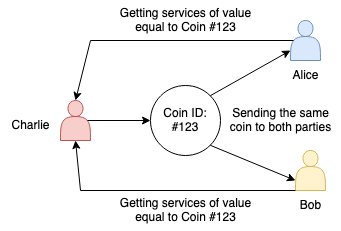

The blockchain can resist against the double spending attack by utilizing the verification mechanism as provided below -

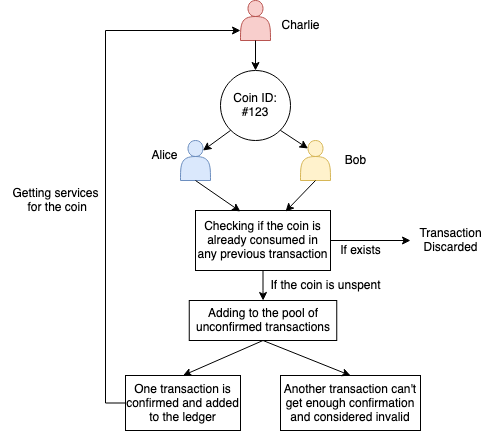

The other attack scenarios are covered in later sections.


In this class, there are other defined methods to support the execution of different attacks:
* **get_random_valid_wallet()** can be used to create a wallet containing all the unspent transactions of a payer.
* **generate_random_valid_transaction()** method generates a valid transaction between two randomly selected users.
* **build_new_transaction()** method is called to create a new transaction given the payer, recipient and the transaction amounts.
     
    

In [ ]:
# Code Block 8
# We are setting up a simulator to run our blockchain.
class RandomSimulator:
    def __init__(self, number_of_users):
        # We will set the total number of users for our blockchain simulation 
        self.number_of_users = number_of_users

        # N number of User objects are created here. These users will be able to send each other Scrooge Coins 
        # Some users may try to take advantage of the system to get some extra coin value
        self.users = [User() for value in range(number_of_users)]

        # Creating a Scrooge instance
        self.scrooge = Scrooge()

        print_console_and_file('LOG: SCROOGE IS CREATING COINS AND ADDING THEM TO THE BLOCKCHAIN')

        # Creating coins for all the users
        self.scrooge.create_user_coins(self.users)
        
        print_console_and_file('LOG: PRINTING USERS AND THEIR BALANCES')

        # Printing the id and balance of every user
        for user in self.users:
            print_console_and_file('ID:' + str(user.get_balance()[0]))
            print_console_and_file('BALANCE:' + str(user.get_balance()[1]))
        print_console_and_file('LOG: PRINTING USERS AND THEIR BALANCES COMPLETE')


    # This method is used to create a wallet containing all the unspent transactions of a payer
    def get_random_valid_wallet(self):
        payer_wallet = [] # wallet to contain the payer's unspent transactions  
        failure_counter = 0
        while len(payer_wallet) == 0:
            # To avoid infinite loops
            if failure_counter == 9999999:
                print_console_and_file(
                    """FAILURE: THE RANDOM SIMULATION REACHED A POINT WHERE NO VALID TRANSACTIONS ARE POSSIBLE. 
                    FAILURE: 9,999,999 trials to generate a new valid transaction failed."""
                    )
                raise Exception('FAILURE: NO VALID TRANSACTIONS ARE POSSIBLE. TERMINATED.')
            else:
                failure_counter += 1
            
            # Retrieving payer and receiver randomly
            [payer, receiver] = random.sample(self.users, 2)

            # Payer's wallet
            payer_wallet = []

            # We will iterate through payer's ewallet to get all the unspent transactions
            for trans_hash_pointer in payer.ewallet:
                spent = False
                
                # Checking the payer's all spent transactions (both published and unpublished)
                for trans_hash_pointer_spent in payer.spent_before + payer.spent_before_temp:
                    if trans_hash_pointer.equals(trans_hash_pointer_spent): 
                        spent = True
                
                # The list of all unspent transactions of the user can be considered as ther current wallet of payer
                if not spent:
                    payer_wallet.append(trans_hash_pointer)

        # print_console_and_file('#########PAYER WALLET#############')
        # print_console_and_file(payer.get_id().export_key()[-100:])
        # for slip in [x.get_pointer().generate_slip() for x in payer_wallet]:
        #     print_console_and_file(slip)
        # print_console_and_file('#########END PAYER WALLET#########')

        return payer, receiver, payer_wallet # Returning the payer and recipient users, and the current wallet of the payer's unspent transactions
    
    # This method can be used to generate list of random payments using payer's wallet
    def generate_payment_from_wallet(self, payer, payer_wallet):
        # Generates a list of random transaction hash pointers from the payer_wallet
        transactions_used_as_basis = random.sample(payer_wallet, k=random.randint(1, len(payer_wallet)))
        
        greater_than = 0.01 # Minimum threshold for the amount to be sent
        to_pay_cumulative = Decimal(str(0)) # Total amount that will be sent
        to_keep_cumulative = Decimal(str(0)) # The amount to be kept to the payer
        previous_transactions_hash_pointers = [] # List of the hash pointers for the consumed coins

        # We will iterate through the list of selected transactions to get total coin values and the previous transactions of those coins
        for transaction_hash_pointer in transactions_used_as_basis:
            transaction = transaction_hash_pointer.get_pointer() # Getting the hash pointer of transaction
            # We will store the total coin values in the selected transactions in this variable
            value = Decimal(str(0))

            # For a transaction, we iterate through the list of created coins in that transaction to calculate total coin values
            for serial_num in transaction.coins_created:
                if transaction.coins_created[serial_num]['recepient'].export_key() == payer.get_id().export_key(): # Checking if the owner of the coin matches the payer
                    value += transaction.coins_created[serial_num]['value'] # Adding up the coin values
                    
                    # The hash pointers for the consumed coins are added to previous_transactions_hash_pointers list
                    previous_transactions_hash_pointers.append(
                        Hash_Pointer(
                            transaction_hash_pointer.get_pointer(), 
                            transaction_hash_pointer.get_hash_value(),
                            serial_num
                            )
                        )

            # Generating a random payment amount to send to the recipient
            to_pay = Decimal(str(round(random.uniform(greater_than, float(value)), 2)))

            to_keep = value - to_pay 

            to_pay_cumulative += to_pay # Total coin values that will be sent
            to_keep_cumulative += to_keep # Total coin values from the transactions that will be kept to the payer

        return to_pay_cumulative, to_keep_cumulative, previous_transactions_hash_pointers, transactions_used_as_basis

    # This method is called to create a new transaction given the payer, recipient and the amounts
    def build_new_transaction(
        self, 
        to_pay_cumulative, # Total amount that will be sent by payer
        to_keep_cumulative, # The amount to be kept to the payer
        previous_transactions_hash_pointers, # List of hash pointers for the consumed coins
        payer,
        receiver
        ):
      
        # If the payer wants to send fraction of total coin values and keep the remaining value in the wallet
        if to_keep_cumulative != 0:
            new_transaction = Transaction(
                'PayCoins',
                previous_transactions_hash_pointers, # List of hash pointers for the consumed coins
                [to_pay_cumulative, to_keep_cumulative],
                [receiver.get_id(), payer.get_id()]
            )
        # If the payer sends all the coin value in the considered transactions, all the coin value is considered spent
        else:
            new_transaction = Transaction(
                'PayCoins',
                previous_transactions_hash_pointers, # List of hash pointers for the consumed coins
                [to_pay_cumulative],
                [receiver.get_id()]
            )
        
        new_transaction.add_signature(payer.sign_transaction(new_transaction.generate_slip())) # The payer signs the new transaction and the signature is added to the transaction object

        return new_transaction

    # This method generates a transaction between two randomly selected users
    def generate_random_valid_transaction(self):
        # Generating a payer and a receiver, and a wallet of payer's unspent transactions
        print_console_and_file('LOG: PICKING TWO RANDOM USERS FOR A VALID TRANSACTION')
        payer, receiver, payer_wallet = self.get_random_valid_wallet()
        
        # A transaction proposal is created from payer's wallet 
        (to_pay_cumulative, # Total amount that will be sent by payer
         to_keep_cumulative, # The amount to be kept to the payer
         previous_transactions_hash_pointers, # List of hash pointers for the consumed coins
         transactions_used_as_basis) = self.generate_payment_from_wallet(payer, payer_wallet)

        print_console_and_file('LOG: PAYER:' + str(payer.get_id().export_key()))
        print_console_and_file('LOG: PAYER WILL PAY:' + str(to_pay_cumulative))
        print_console_and_file('LOG: PAYER WILL KEEP REMNANT:' + str(to_keep_cumulative))
        print_console_and_file('LOG: TOTAL:' + str((to_pay_cumulative + to_keep_cumulative)))
        
        # A transaction is created from the transaction proposal 
        new_transaction = self.build_new_transaction(
            to_pay_cumulative, # Total amount that will be sent by the payer
            to_keep_cumulative, # The amount to be kept to the payer
            previous_transactions_hash_pointers, # List of hash pointers for the consumed coins
            payer,
            receiver
            )

        # Adding the new transaction to the temporary list of transactions that will be published in a block
        transaction_passed, published_new_block = self.scrooge.add_transaction(new_transaction, payer.get_id())

        # If the transaction is valid, a hash pointer is created using the transaction along with its signature
        if transaction_passed:
            new_transaction_hash_pointer = Hash_Pointer(
                new_transaction, 
                SHA512.new(new_transaction.get_signature())
                )
            
            if to_keep_cumulative != 0: # Amount to be sent is non-zero value
                payer.ewallet_temp.append(new_transaction_hash_pointer) # Updating payer's "temporary" wallet as the transaction is yet to be published
                print_console_and_file('LOG: REMNANT TO BE ADDED TO PAYER WALLET.')
            
            # New spent transactions are added to the spent_before_temp transaction list of the payer
            # When these transactions will be added to a block, they will be added to the spent_before list in user object
            for x in transactions_used_as_basis:
                payer.spent_before_temp.append(x)
            
            # Updating recipient's "temporary" wallet with the new created transaction
            receiver.ewallet_temp.append(new_transaction_hash_pointer)

            # If a block is already created after adding the new transaction to the temporary list of transactions, the users will be notified so that their wallets can be updated accordingly
            if published_new_block:
                for user in self.users:
                    user.notify_block_published()

            print_console_and_file('LOG: TRANSACTION COMPLETE')
            return True, new_transaction.generate_slip()
        else:
            print_console_and_file('ERROR: TRANSACTION FAILED')
            return False, None

    # This method is used to perform Double Spending Attack on the blockchain
    def double_spend(self):
        print_console_and_file('LOG: PICKING TWO RANDOM USERS FOR A DOUBLE SPENDING ATTACK')
        
        # Retrieving a random payer from the list of users
        payer = None
        for user in random.sample(self.users, len(self.users)):
            # Checking if the user already have any spent transactions
            # It means that the user already have coins in its address
            if len(user.spent_before + user.spent_before_temp) != 0: 
                payer = user
                break
        
        # Payer couldn't be decided as no coin has been spent yet
        if payer is None:
            print_console_and_file('LOG: CANNOT GENERATE DOUBLE SPENDING TRANSACTION BECAUSE NO COINS HAVE BEEN SPENT YET.')
            return False, False

        # Retrieving a random receiver from the list of users
        receiver = random.sample(self.users, len(self.users))[0]
        
        # A wallet containing all the published and unpublished spent transactions of the payer
        # Choosing from already spent transactions will lead to the double spending of the same coin
        payer_wallet = payer.spent_before + payer.spent_before_temp

        # A transaction proposal is created from payer's wallet        
        (to_pay_cumulative, # Total amount that will be sent by payer
         to_keep_cumulative, # The amount to be kept to the payer
         previous_transactions_hash_pointers, # List of hash pointers for the consumed coins
         transactions_used_as_basis) = self.generate_payment_from_wallet(payer, payer_wallet)

        # A transaction is created from the transaction proposal 
        new_transaction = self.build_new_transaction(
            to_pay_cumulative, # Total amount that will be sent by payer
            to_keep_cumulative, # The amount to be kept to the payer
            previous_transactions_hash_pointers, # List of hash pointers for the consumed coins
            payer,
            receiver
        )

        print_console_and_file('LOG: GENERATED THE FOLLOWING DOUBLE SPENDING ATTACK:')
        print_console_and_file('LOG: PAYER:' + str(payer.get_id().export_key()))
        print_console_and_file(new_transaction.generate_slip())

        return self.scrooge.add_transaction(new_transaction, payer.get_id()) # The new transaction is added to the list of temporary transactions which will be published in a block later
    
    # This method is used to perform Fake Signature Attack on the blockchain
    def execute_fake_signature_attack(self):
        # Generating a payer and a receiver, and a wallet containing the unspent transactions of the payer
        print_console_and_file('LOG: PICKING TWO RANDOM USERS FOR A VALID TRANSACTION')
        payer, receiver, payer_wallet = self.get_random_valid_wallet()
        
        # Generating a transaction proposal
        (to_pay_cumulative, # Total amount that will be sent by payer
         to_keep_cumulative, # The amount to be kept to the payer
         previous_transactions_hash_pointers, # List of hash pointers for the consumed coins
         transactions_used_as_basis) = self.generate_payment_from_wallet(payer, payer_wallet)
        
        # Generating a transaction from the proposal
        new_transaction = self.build_new_transaction(
            to_pay_cumulative, # Total amount that will be sent by the payer
            to_keep_cumulative, # The amount to be kept to the payer
            previous_transactions_hash_pointers, # List of hash pointers for the consumed coins
            payer,
            receiver
            )

        print_console_and_file('LOG: ADDING A FAKE SIGNATURE.')
        # After creating the transaction, a fake signature is created by signing the transaction using receiver's key instead of payer's
        fake_signature = receiver.sign_transaction(new_transaction.generate_slip()) 
        new_transaction.add_signature(fake_signature) # The fake signature is added to the new transaction

        print_console_and_file('LOG: GENERATED THE FOLLOWING FAKE SIGNATURE ATTACK:')
        print_console_and_file('LOG: PAYER:' + str(payer.get_id().export_key()))
        print_console_and_file('LOG: FAKE SIGNATURE:' + str(fake_signature))
        print_console_and_file(new_transaction.generate_slip())

        return self.scrooge.add_transaction(new_transaction, payer.get_id()) # Trying to add the transaction with fake signature (Fake Signature Attack) to the list of temporary transactions that will be published later
    
    # This method is used to perform Fake Amount Attack on the blockchain
    def execute_fake_amount_attack(self):
        print_console_and_file('LOG: PICKING TWO RANDOM USERS FOR A VALID TRANSACTION.')
        
        # Generating a payer and a receiver, and a wallet containing the unspent transactions of the payer
        payer, receiver, payer_wallet = self.get_random_valid_wallet()
        
        # Generating transaction proposal using payer's wallet
        (to_pay_cumulative, # Total amount that will be sent by payer
        to_keep_cumulative, # The amount to be kept to the payer
        previous_transactions_hash_pointers, # List of hash pointers for the consumed coins
        transactions_used_as_basis) = self.generate_payment_from_wallet(payer, payer_wallet)
        
        print_console_and_file('LOG: TAMPERING WITH TRANSACTION AMOUNT BY ADDING 100 TO FIRST RECEPIENT.')

        # Generating a transaction for the transaction proposal
        new_transaction = self.build_new_transaction(
            to_pay_cumulative + Decimal('100'), # Tampering the payment amount (Fake Amount Attack) while creating the new transaction
            to_keep_cumulative, # The amount to be kept to the payer
            previous_transactions_hash_pointers, # List of hash pointers for the consumed coins
            payer,
            receiver
            )
        
        print_console_and_file('LOG: GENERATED THE FOLLOWING FAKE TRANSACTION AMOUNT ATTACK:')
        print_console_and_file('LOG: PAYER:' + str(payer.get_id().export_key()))
        print_console_and_file(new_transaction.generate_slip())

        return self.scrooge.add_transaction(new_transaction, payer.get_id()) # Trying to add the transaction with fake amount (Fake Amount Attack) to the list of temporary transactions that will be published later
    
    def execute_unowned_coins_attack(self):
        # generate a payer and a receiver
        print_console_and_file('LOG: PICKING TWO RANDOM USERS FOR A VALID TRANSACTION.')
        payer, receiver, payer_wallet = self.get_random_valid_wallet()
        
        # generate payment
        (to_pay_cumulative, 
        to_keep_cumulative, 
        previous_transactions_hash_pointers, 
        transactions_used_as_basis) = self.generate_payment_from_wallet(payer, payer_wallet)
        
        # generate transaction
        print_console_and_file('LOG: SWITCHING PAYER AND RECEIVER TO PRODUCE A TRANSACTION WITH UNOWNED COINS.')
        new_transaction = self.build_new_transaction(
            to_pay_cumulative, 
            to_keep_cumulative,
            previous_transactions_hash_pointers,
            receiver,
            payer
            )
        
        print_console_and_file('LOG: GENERATED THE FOLLOWING UNOWNED COINS ATTACK:')
        print_console_and_file('LOG: PAYER:' + str(receiver.get_id().export_key()))
        print_console_and_file(new_transaction.generate_slip())

        return self.scrooge.add_transaction(new_transaction, receiver.get_id())
    
    def execute_non_existent_coins_attack(self):
        # generate a payer and a receiver
        print_console_and_file('LOG: PICKING TWO RANDOM USERS FOR A VALID TRANSACTION.')
        payer, receiver, payer_wallet = self.get_random_valid_wallet()
        
        # generate payment
        (to_pay_cumulative, 
        to_keep_cumulative, 
        previous_transactions_hash_pointers, 
        transactions_used_as_basis) = self.generate_payment_from_wallet(payer, payer_wallet)

        print_console_and_file('LOG: TAMPERING WITH TRANSACTION AMOUNT BY ADDING NON-EXISTENT COIN.')
        previous_transactions_hash_pointers[0] = Hash_Pointer(
            previous_transactions_hash_pointers[0].get_pointer(),
            previous_transactions_hash_pointers[0].get_hash_value(),
            -1
        )
        
        # generate transaction
        new_transaction = self.build_new_transaction(
            to_pay_cumulative, 
            to_keep_cumulative,
            previous_transactions_hash_pointers,
            payer,
            receiver
            )
        
        print_console_and_file('LOG: GENERATED THE FOLLOWING NON-EXISTENT COIN ATTACK:')
        print_console_and_file('LOG: PAYER:' + str(payer.get_id().export_key()))
        print_console_and_file(new_transaction.generate_slip())

        return self.scrooge.add_transaction(new_transaction, payer.get_id())

    def execute_double_spend_unspent_coin_attack(self):
        # generate a payer and a receiver
        print_console_and_file('LOG: PICKING TWO RANDOM USERS FOR A VALID TRANSACTION.')
        payer, receiver, payer_wallet = self.get_random_valid_wallet()
        
        # generate payment
        (to_pay_cumulative, 
        to_keep_cumulative, 
        previous_transactions_hash_pointers, 
        transactions_used_as_basis) = self.generate_payment_from_wallet(payer, payer_wallet)
        
        # generate transaction
        print_console_and_file('LOG: TAMPERING WITH TRANSACTION AMOUNT BY DOUBLE-SPENDING A COIN.')
        
        trans_to_duplicate = previous_transactions_hash_pointers[0]
        previous_transactions_hash_pointers.append(
            Hash_Pointer(
                trans_to_duplicate.get_pointer(),
                trans_to_duplicate.get_hash_value(),
                trans_to_duplicate.get_coin_serial_num()
            )
        )
        to_pay_cumulative += trans_to_duplicate.get_pointer().coins_created[trans_to_duplicate.get_coin_serial_num()]['value']
        
        new_transaction = self.build_new_transaction(
            to_pay_cumulative, 
            to_keep_cumulative,
            previous_transactions_hash_pointers,
            payer,
            receiver
            )
        
        print_console_and_file('LOG: GENERATED THE FOLLOWING DOUBLE-SPEND UNSPENT COIN ATTACK:')
        print_console_and_file('LOG: PAYER:' + str(payer.get_id().export_key()))
        print_console_and_file(new_transaction.generate_slip())

        return self.scrooge.add_transaction(new_transaction, payer.get_id())


# Examining the Transactions and the Execution of Individual Attacks

## Simulating Transactions

We will generate 50 transactions for the given number of users at first which we will use as the basis transactions while generating transactions during attack simulations. 

While generating a transaction - <br> 
* Two random users are selected from the list of users as the payer and the recipient of the transaction. 
* Then, some transactions will be randomly picked from the payer's wallet which will be used as the basis or input on this transaction. 
* The total coin value in the selected transaction will be calculated. 
* A coin value will be randomly selected (can be fractional and less than the calculated) tolal coin value. This selected amount will be sent to the recipient and the remaining value will be kept unspent.
* A new transaction will be generated using the chosen **coin value** and the **recipient** of that coin value.


In the output of the next code block, the json objects represent the generated transactions.
* The **coin_consumed** attribute list the input coins of the transaction along with their source transactions where the coins are unspent. 
* Within **coin_created** attribute, there are two elements present. The first element (index 0) represent the recipient and the amount to be send to recipient. The second element (index 1) represent the payer and the remaining amount which is sent back to the payer.

In the output, 10 users are created at first and coins are created for the users in form of transactions. The public keys and balances of the users are printed. 

For each transaction, a fraction of total consumed coin value is chosen which will be sent to the recipient of the transaction. And, the remainder will be kept to the payer.

50 transactions are displayed as json objects where each json contains the datails of consumed coins and output coins in a transaction including the identifier and the calculated hash of the associated transactions.



In [ ]:
# Code Block 9
number_of_transactions = 50
simulator = RandomSimulator(NUMBER_OF_USERS)

for i in range(number_of_transactions):
    print_console_and_file('##################################')
    print_console_and_file('#### Transaction Count:' + str(i+1) + ' ####')
    success, transaction_slip = simulator.generate_random_valid_transaction()
    print(transaction_slip)
    print_console_and_file('##################################')

LOG: SCROOGE IS CREATING COINS AND ADDING THEM TO THE BLOCKCHAIN
LOG: PRINTING USERS AND THEIR BALANCES
ID:b'-----BEGIN PUBLIC KEY-----\nMIIDQjCCAjUGByqGSM44BAEwggIoAoIBAQCmQj+bMM9/qj2BZk/2joHzjwkFKqwr\ncq9AqBIflnUywY+h3WEEl5YEUdL5H/LeoUXtwaoV4Z/54PDJcA3u7R/SN13Cw+oc\n1+3MRhYxVQW+kMqaAgvuiLG1nRoDMe4LbOCjFVgUimgdzUGJ9HvclDp8EwRpBxWk\nEOXxxVZT1uktUkXbXQ6RpXsykXegdI4otvVevyPyBAUgBihn1PUMKuwnXuiE/sC+\njawtc2JtJG6bXVpcq2tiqbzkEaMnda8DF9EtppiHe2ZP22ynIVrdXwLjcUojJ5Y9\nE+TBTfWpK55KfYJhkEUc8WA6hA14qwDBfYt0h+eYfcLaaEFVvALOzjGJAh0ApXIU\niWj0BLh/AXDWk/kMZTsLHfMMsftWwqFe7wKCAQBp7bcRrCAZVHLN2mUTFd0MenzA\nAvHziW+SuaOeHvsWZ/AbLpiS93c091B7Po4W9sVeguZtU/BY+G6VzzuVZGhtkjpE\nXqZTZ7u/wUkU7jwir4ptmsApt4cs6Ncb3NZUI7JCglDSw+yUpPM6eHTlYYjFpNb6\nirkrLKy9s2lI/tcJP52ZDdh4TUH64xwYQROSxy9c9kmuK0ZuqkAJMDVadqSl+eo+\n58OJTlaCJ2v03oWMkiLyl0G9ONjAMrw7QRxaNjiDvrdj22XvYvldgs/6hw0jWThK\ngGtGB0yiOGDBf3nX6lvGfzi0JAcKaew/ZC0788C6BiTLWNKE+4hgonMy/cOlA4IB\nBQACggEALRV0r01nAuhlMagL6IGYha7hqjkQnX9QXwfehP3YoP4n55qrAM4kwfl0\n9OQd7

# Execution of Double Spending Attack


For executing double spending attack, two random users are chosen as the payer and the recipient. For generating a valid transaction, the input basis transactions are chosen from the unspent transactions in payer's wallet. 

To simulate the attack, the basis transaction will be chosen from the collection of payer's spent transactions. So, the input coins of the newly generated transaction are already spent. 

To repel this attack, the basis transactions are compared against all the previous confirmed transactions in the ledger by iteration all the blocks from the final block till the genesis block.

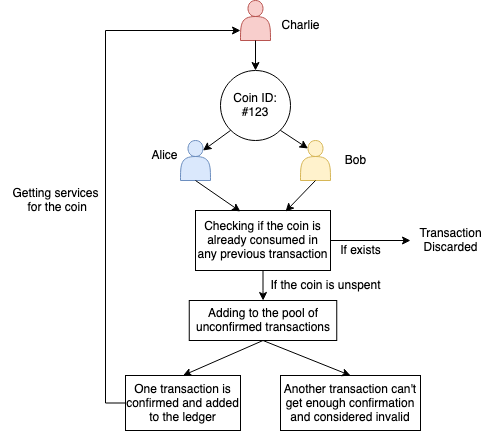

In [ ]:
# Code Block 10
x, y = simulator.double_spend()

LOG: PICKING TWO RANDOM USERS FOR A DOUBLE SPENDING ATTACK
LOG: GENERATED THE FOLLOWING DOUBLE SPENDING ATTACK:
LOG: PAYER:b'-----BEGIN PUBLIC KEY-----\nMIIDQzCCAjYGByqGSM44BAEwggIpAoIBAQDexWfxKiOfmFdu5gKcDPcRkq2zvSOS\nUqvQVKWY/E3khcAPEA39dsrhBXBimZTEoLb2mf8pqxZb2yk/FfwfhMoRkCoP06LE\ntLPmqLD3zEzwg71aTX5Grm9o/2j3qCTPRLPVEVHGmA7hq9lfdtonm1JlEeJT3A6O\nJgPdXZXlkaKonEbabzHLNPysvDjEoFAyPEZnkz8ZoO8o+tnf3q0eFGhdIeUU5nD0\nEA1ExZ/shKYBU7hdtkk1IYhnEJxs1Y0lLJE6/i2N4r1iXUq373gnIbKM61IUjjW6\ndhoJY1EDfLGgSlR297iAOg1RsfXiLSbaRZBrcdxNGzH98JcTY2l4BV8DAh0A0nao\nv4EvBwgtPE0FYcYY8N4oDPwBu4QbzWe+5wKCAQEAqJtQmI4BC7Cqsemb1rnhZKn5\nwhhTMLzJKUp/MV1aAlHWD4tl2udjx5GsN8lVa3qAutwSilZpF4wROmGAnnveHteZ\n4D1tzM2drlWWMisUTLca/ArN65o1NXslEDsVeyVdzs8JqCVBCwP2MG0DCTs7ZlVu\n1W/CSaGExW6LeYO7Z999o31A084Hs6iMloy5B754MyVCghoPI2lEDiLSFn8OhFTx\nSQ0JNVH0KD/1te98XY/aoMyCtAoUWUZrAxqeaohT9ujiLaswS44m8ySMo64trL13\nLl95N9kXk/wLKUJ29XaoRsww1KIeEFPz/jGCmSwVJAmRiK6Qb+1lvcDiAQrL6QOC\nAQUAAoIBAE+CkEWFEnju8nsFV5p8ei/eIlv2/2oP3r4GN7F2eTWCwX8

# Execution of Fake Signature Attack

First, two random users are chosen as the payer and the recipient, and a transaction is generated which is represented by the json object.

Before the transaction is added to a block, digital signature is generated for this transaction using the private key of the payer. This digital signature is verified before the transaction is approved and finalized.

To simulate the attack, we will sign the transaction with the **private key** of other user (e.g. recipient) instead of payer's key before adding the transaction to the list of temporary transactions (which will be verified, approved and added to the ledger later).

To repel this fake signature attack, the digital signature associated with the transaction will be verified using the **public key** of the payer during the approval phase. 

Referring to the flow of this mechanism:

>>> 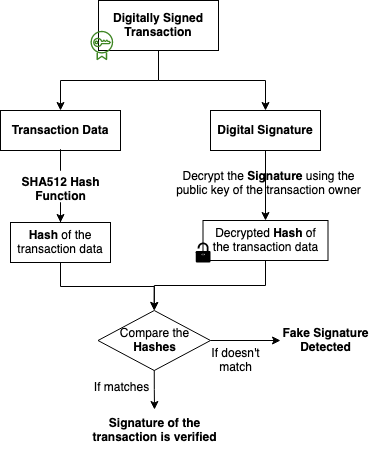

In [ ]:
# Code Block 11
x, y = simulator.execute_fake_signature_attack()

LOG: PICKING TWO RANDOM USERS FOR A VALID TRANSACTION
LOG: ADDING A FAKE SIGNATURE.
LOG: GENERATED THE FOLLOWING FAKE SIGNATURE ATTACK:
LOG: PAYER:b'-----BEGIN PUBLIC KEY-----\nMIIDQzCCAjUGByqGSM44BAEwggIoAoIBAQCVeC2nOILr5+bl4DeTL7uAXlMiSWlu\nzXJcWsRa2aLq4oVhdV0nxA6PAmDCkTSTzLC1omz/YSkxUWkfYbZOduAHUyL10vrA\nQ7aA34ynToKKXC0m7o5mLxFSLjsSMyoaC+tBM0efYgsGUD67ZRMI3g1j71/Hvdbz\nSq/giVf4+/dnkpYenIMEVZ1e9rhuKFy+oFircY2HV29w5KJHG3OZ3SsYQFX/V0Xa\nyCxryDs0YhQqo8cLkFekxJi6Lfg0Tj9/fP7Pa1kG72LFZyRzGWL+C4GyieeRLKcX\nbDk8o+8AL9mkTKQBHgbhp8W2alyY/71p2XhHp5Y0aAl4KitAQMeu9gH/Ah0A3W3Z\nU/LN4LHqAB0agv62tmQ9flRraQykQbZVZQKCAQBIryaWwIoLbQNLwIpiddrRM1qa\nM18svOBURcALsvuOzrysUL7hFTXrFhzKOqlxqSzzaVMXEQvmAKqdp054HhEtHZpn\nsT02kqNXSuXrYjgQPaMlfC/GPvSWQRt0Ca3RmqRO2VEFHv06xDvySdjBGG25tZ3I\nDfghXum2+8JBDN5fz/Md671qNba8Zos79fCNqP1wbT2eQKoaG4LC+1eL1GmyjYCO\nXPzLtWCSeaf8S8NucK66yVgZ/qnvQ3vAbnHjwJsRmI21M87SnEo9OOC/mn3uGDgE\n/or+73K+1jJG6Gwoo1qfkiM/ECmcFhYyxPoZ09colLg6SSAErpyLJubAazaOA4IB\nBgACggEBAIg2gZdB8O6ugJbGEKsZDVB

# Fake Amount Attack

To simulate fake amount attack, two random users are selected as the payer and the recipient. Then, payment proposal is generated from the unspent transactions of the payer's wallet. 

To execute the attack, while creating a transaction from the payment proposal the amount to transfer is modified. A successful attack would lead to receive extra amount in the transaction.

This attack is defended during the verification phase before the transaction is added to list of unconfirmed transactions. The amount of coin value consumed in the transaction is compared with the summation of coin value for the recipient and the amount to send back to the payer. As, when under attack, the amount for the recipient is altered, both the coin values won't match. It will result in failed transaction.

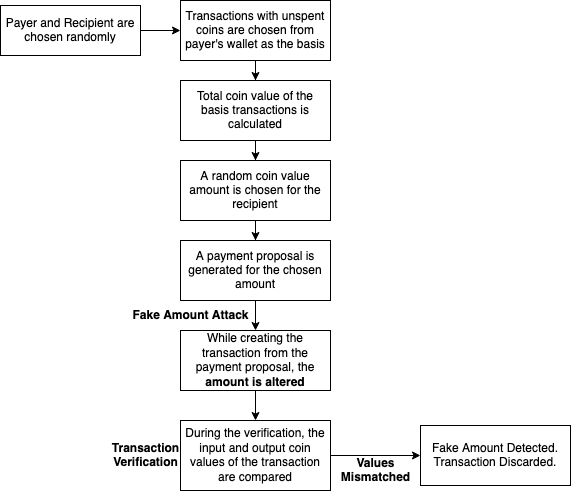

In [ ]:
# Code Block 13
x, y = simulator.execute_fake_amount_attack()

LOG: PICKING TWO RANDOM USERS FOR A VALID TRANSACTION.
LOG: TAMPERING WITH TRANSACTION AMOUNT BY ADDING 100 TO FIRST RECEPIENT.
LOG: GENERATED THE FOLLOWING FAKE TRANSACTION AMOUNT ATTACK:
LOG: PAYER:b'-----BEGIN PUBLIC KEY-----\nMIIDRDCCAjYGByqGSM44BAEwggIpAoIBAQCnMfoZKMOGZ1+uBLyB4XE1/+95dedp\ncBCl/RR/Cm8hR7gNipagzMw3/YbbFdFsrbfYkVfdA1seVrRpCdPSIfiB/OvhTryo\n68c1Z95p/u+uYrD7tSfCkw2c+8d0quSS8OX3luZDds2AO9YZbdoKb5SQhOHg6057\nLlc1DPR7g7eTcByZePj9p9+IgqkGtck4ZPgn7mJC14SD/Zif5jr3wTIAHLVccr8Y\nWMAQXzxal8jk8fI4P6P6bMXKZOY5AhJzG9Tb9iWZJF/tyo0b7m9kfcm+iWnWEQ5o\nbl8F5Y6458vu38zpnDjRnyxvwDeLqeDI6iHbT2YjAdWKsDnnwqk3tHU9Ah0AvdPU\nPOAiWMzMjZqG2axb+7UJcwI3nQG07nU06QKCAQEAkIQLLET5y+PupIJyslLcPrc9\neP9ZDr1khmqT6aQgwF5DcQtgBLTmT6A2uJ6G+fUiIWNZN0/xrn9BCTkdKNFecT4H\nTC+X6+LN/15P431cp4UX8giBToeYh6YmSJmInCCbpESUzvf4LywAJmf+awejp6/N\nKCWhlRRJ5gYnt6T1CYGrlLAM8En11j0ctcBh5SQS7XV91MlrTSsHmGGNy5xVLmNG\nghY2FnPLFNjymL15YvWSXegMRw3QY37DPtsgSXkbtiftJqrzHrb7et/z9WAfRe4H\n4Zk51Wi/MdqzDXXBGbQ5yr8V7zoPx5Hcb+vczXe8mJMc

# Simulating Events

We will now simulate **Transactions** and different types of attack scenarios (**Double Spending**, **Fake Signature**, **Fake Amount**, etc) in the blockchain based on the probabilistic distribution of the events. 

* For **Transactions**, our simulation will generate a random number between 1 and 10 as the count of transactions. The simulation will then generate random transactions for that count. In the simulation, 10% events will be for generating transactions. 

* **Double Spending Attack** occurs when a user tries to spend any coin which is already spent once. 40% of the events will simulate the double spending attacks.

* **Fake Signature Attack** occurs when a user attempts to spend the coins owned by other users by faking the identity of the coin's owner. 30% of the events will simulate fake signature attacks.

* In **Fake Amount Attack**, a malicious user tries to tamper the transaction amount while creating a transaction. 20% of the events will simulate fake amount attacks.

In [ ]:
# Code Block 14

from collections import Counter

# This method simulates transactions and different events based on probabilistic distribution
def simulate_events(event_count): 
    with open('output.txt', 'w') as file_out:
        print('LOG: STARTING SIMULATION', file=file_out)
    
    simulator = RandomSimulator(NUMBER_OF_USERS) # Initializating RandomSimulator with given number of users

    # Creating a list of events for the simulation based on the probabilities of different events
    event_list = np.random.choice(
      ['transaction', 'ds_attack', 'fs_attack', 'fa_attack'], 
      event_count,
      p=[0.1, 0.4, 0.3, 0.2]
    )
    # print(event_list)

    # Printing the distribution of events
    print(Counter(event_list)) 

    for event_id in range(len(event_list)):
      print("##############  Event ",event_id+1," ############")
      # Generating random transactions
      if event_list[event_id] == 'transaction':
        number_of_transactions = random.randint(1, 10) # Choosing random transaction count between 1 and 10
        print("Event#",event_id+1,":Generating Random",number_of_transactions,"Transaction/s")
        for i in range(number_of_transactions):
          print_console_and_file('##################################')
          print_console_and_file('#### Transaction Count:' + str(i+1) + ' ####')
          success, transaction_slip = simulator.generate_random_valid_transaction()
          print(transaction_slip)
          print_console_and_file('##################################')
      # Double Spending Attack    
      elif event_list[event_id] == 'ds_attack': 
        print("Event#",event_id+1,":Performing Double Spending attack")
        x, y = simulator.double_spend()
        if (not x) and (not y):
              print_console_and_file('Event#'+str(event_id+1))
              print_console_and_file('LOG: DOUBLE SPENDING ATTACK FAILED.')
      # Fake Signature Attack
      elif event_list[event_id] == 'fs_attack':
        print("Event#",event_id+1,":Performing Fake Signature attack")
        x, y = simulator.execute_fake_signature_attack()
        if (not x) and (not y):
              print_console_and_file('Event#'+str(event_id+1))
              print_console_and_file('LOG: FAKE SIGNATURE ATTACK FAILED.')
      # Fake Amount Attack
      elif event_list[event_id] == 'fa_attack':
        print("Event#",event_id+1,":Performing Fake Amount attack")
        x, y = simulator.execute_fake_amount_attack()
        if (not x) and (not y):
              print_console_and_file('Event#'+str(event_id+1))
              print_console_and_file('LOG: FAKE AMOUNT ATTACK FAILED.')

Calling the function will execute 100 events which can be **creating transactions**, performing **double spending**, **fake signature** and **fake amount** attacks. 

In [ ]:
# Code Block 15
# Number of events to simulate
num_of_events = 100
simulate_events(num_of_events)

LOG: SCROOGE IS CREATING COINS AND ADDING THEM TO THE BLOCKCHAIN
LOG: PRINTING USERS AND THEIR BALANCES
ID:b'-----BEGIN PUBLIC KEY-----\nMIIDQzCCAjUGByqGSM44BAEwggIoAoIBAQDxry9YGKkS84IN8llzNVwEtfRR1JHK\nh8GkXnL0cQaQIq8cOYPk+WotbeIEfLvLrSBZNE+ghVY6UwN3X39gYMNuCtW6ruTu\nuDYZCNANKE3vHxdstkwl+EVzF0M5Qs1zaV+kqxKcTw1fAdUicQ0mVkEyLJEr3JHW\nUt0CdtmU/csjkN6RRdHxv0Rq33AcKVHGCPnPVuNt2JM0+RubGzNDvBGCAVF1Ucq7\ns9LAz3/Ruxk8V/l1Yw/54Vg+26yKt1EZPAHwDfYMVZlgzi42ZzDXmm1QZFQzEqpt\nfKRVfav4GsUXieigAWHJA65eUEuGe6lIBXZl8PEqelgj4waDFU97/FBRAh0AsOtc\nkpvUwVCAml4x9Qc0zPQxj2/PzSytYm6X+QKCAQAl45Y933Y5zDCCWq/noNL1XcBP\nOZ1lCu6Rd7Dz26n2L6x+L6t6QYn10xv8dzpFoYgKr/y4/jv/jqNoYD90Sm5k/kky\nH5LYhri9cjADPmtrRDjCMpSME7kjlUfPz0HZRvOdbmYjcXjUPD1/8g26jbKjgp9E\nxqoJ7KX8SrvQlYCg9GDEvMVmi/RWUB8zotpOW/I8QWDV/VWmmcGug8bDJG8Lb8KG\nT0OCDMmqi0EC4ODDV/CFfA2De3CM53V2MKVHPgnzo+hner4J3PsOFz58AMo3cKrx\nzRH1np/z9yK1YwBegYXupcxv/hJ8BnMRxWzHOeiqDddGhVwkn2ZcvRWQjDuXA4IB\nBgACggEBALgTp8nHTdPGN+xlpcu8s3FZkq0B7aYaN1Es/toO326Eq+EqNHbzRxUZ\nEfMYL

# Displaying the Ledger

We can fetch whole the ledger instance as a dictionary object. 

Each element in the dictionary represent a block. 

Each block contains 10 transactions (block threshold). 


In [ ]:
# Code Block 16

blockchain_obj = json.loads(simulator.scrooge.blockchain.generate_blockchain_string()) # Blockchain ledger
print("Block Count: ",len(blockchain_obj))

# Getting the list of keys to access the blocks in th ledger
# The last key in the list points to the Genesis block
# The first key in the list points to the final block
block_keys = list(blockchain_obj.keys())

# Printing the keys in the dictionary to access the blocks
print("Pointers to Access the Blocks:")
for i in block_keys:
  print(i)

Block Count:  7
Pointers to Access the Blocks:
final_block_hash_pointer


The **first** block or **genesis** containing the information of 10 transactions is displayed here. Note that the **previous_block_pointer** is **None** for the first block as it doesn't hold pointer to any other block. The other blocks maintain pointers to their previous block.


In [ ]:
# Code Block 17

first_block_index = len(block_keys)-1 # Pointer index of the genesis block
print(json.dumps(blockchain_obj[block_keys[first_block_index]], sort_keys=True, indent=4, separators=(',', ': ')))

{
    "block_id": "<__main__.Block object at 0x7f19e67f6970>",
    "hash": "e1ae9fd05c2a10000d4f39d3fa11e53ff860f443558db49e742b652d927e87583ee524208a6df969b4a221c32742c251b047079ab5c5a57f6e971fe32255dd54",
    "previous_block_hash_value": null,
    "previous_block_pointer": "None",
    "transactions": {
        "0": {
            "signature": "b'\\xcdo\\xb8\\xe3\\xd9tq\\x93\\x8c\\xd4\\xbeP\\xce\\x9c\\x16\\x97\\xee]\\x1c{\\x95\\x957\\x8b\\xe7\\xed\\x83u\\x04\\xe5\"\\xc1\\xc4w\\xd7Q\\xb8\\xc3V\\xf7#)\\xc30(@i3!\\xbd\\xf5\\x11c\\xb5\\xcfj'",
            "transaction_body": {
                "coins_consumed": {},
                "coins_created": {
                    "0": {
                        "recepient": "-----BEGIN PUBLIC KEY-----\nMIIDQjCCAjUGByqGSM44BAEwggIoAoIBAQCmQj+bMM9/qj2BZk/2joHzjwkFKqwr\ncq9AqBIflnUywY+h3WEEl5YEUdL5H/LeoUXtwaoV4Z/54PDJcA3u7R/SN13Cw+oc\n1+3MRhYxVQW+kMqaAgvuiLG1nRoDMe4LbOCjFVgUimgdzUGJ9HvclDp8EwRpBxWk\nEOXxxVZT1uktUkXbXQ6RpXsykXegdI4otvVevyPyBAUgBihn1PUMKuwn